In [3]:
!pip install kaggle

Step#1 **Import Necessary Libraries**

In [4]:
import os
import json

from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import re
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report



Gather Kaggle Api-Key + collect Data

In [5]:
kaggle_dictionary = json.load(open("/content/kaggle.json"))

In [6]:
kaggle_dictionary.keys()

dict_keys(['username', 'key'])

In [7]:
# setup kaggle credentials as environment variables
os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

In [8]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls

'IMDB Dataset.csv'			 kaggle.json   results
 imdb-dataset-of-50k-movie-reviews.zip	 logs	       sample_data


In [10]:
# unzip the dataset file
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
  zip_ref.extractall()

In [11]:
!ls

'IMDB Dataset.csv'			 kaggle.json   results
 imdb-dataset-of-50k-movie-reviews.zip	 logs	       sample_data


Step#2 **Performing EDA + Load** **Data**

In [13]:
df=pd.read_csv("IMDB Dataset.csv")

In [13]:
df.shape

(50000, 2)

In [14]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<ipython-input-15-1d41f95452c2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


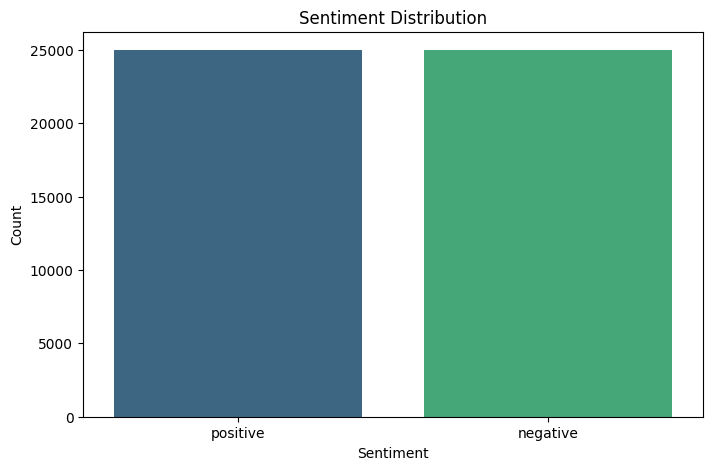

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [16]:
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [17]:
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

<ipython-input-17-0554edc9e970>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


In [18]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [19]:
df["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


In [20]:
# split data into training data and test data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

Step#3 **Pre-Processing of Data**

In [21]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [22]:
# using stopwords from nltk

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Remove HTML Strip and Special Characters
tag = random.randint(0, len(df)-1)
before_process = df.iloc[tag][0]

def process(a):
    a = re.sub('[,\.!?:()"]', '', a)
    a = re.sub('<.*?>', ' ', a)
    a = re.sub('http\S+', ' ', a)
    a = re.sub('[^a-zA-Z0-9]', ' ', a)
    a = re.sub('\s+', ' ', a)
    return a.lower().strip()

df['review'] = df['review'].apply(lambda a: process(a))
after_process = df.iloc[tag][0]

<ipython-input-23-a5b6be8a447d>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  before_process = df.iloc[tag][0]
<ipython-input-23-a5b6be8a447d>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  after_process = df.iloc[tag][0]


In [24]:
nltk.download('punkt_tab')
def sw_remove(a):
    words = nltk.tokenize.word_tokenize(a)
    filtered_list = [word for word in words if word not in stop_words]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda a: sw_remove(a))
after_removal = sw_remove(after_process)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [32]:
from nltk.stem import PorterStemmer,WordNetLemmatizer
def stemmer(a):
  ps=nltk.porter.PorterStemmer()
  text= ' '.join([ps.stem(word) for word in a.split()])
  return text

try:
    df['review'] = df['review'].apply(stemmer)
except KeyboardInterrupt:
    print("Stemming process interrupted. Saving progress...")
    # Add code to save any intermediate results or perform cleanup here

In [ ]:
df.head()

In [27]:
print(X_train)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [28]:
print(X_test)

[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [29]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [30]:
print(Y_train)

39087    negative
30893    negative
45278    positive
16398    negative
13653    negative
           ...   
11284    positive
44732    positive
38158    negative
860      positive
15795    positive
Name: sentiment, Length: 40000, dtype: object


Step# 4 **Feature Extraction**

In [25]:
norm_train_reviews=df.review[:40000]
norm_train_reviews[0]
norm_test_reviews=df.review[40000:]
norm_test_reviews[45005]


'read reviews watching piece cinematic garbage took least 2 pages find somebody else think appallingly unfunny montage acme humour 70s indeed era least funny set sketch comedy ever seen till comes along half skits already done infinitely better acts monty python woody allen say nice piece animation lasts 90 seconds highlight film would still get close summing mindless drivel ridden waste 75 minutes seminal comedy world seminal really mean semen scatological humour world scat actually feces precursor jokes mean handbook comedy tits bums odd beaver niceif pubescent boy least one hand free found playboy exists give break early 70s way sketch comedy going back least ten years prior way could even forgive film even made gunpoint retro hardly sketches clowns subtly perverting children may cutting edge circles could actually funny comes really quite sad kept going throughout entire 75 minutes sheer belief may saved genuinely funny skit end gave film 1 lower scoreand recommend insomniacs coma 

In [26]:
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews[:40000])  # Process only 40000 reviews
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 7116132)
BOW_cv_test: (10000, 7116132)


In [30]:
lb=LabelBinarizer()
sentimentdata=lb.fit_transform(df['sentiment'])
print(sentimentdata.shape)

(50000, 1)


In [32]:
train_sentiment=sentimentdata[:40000]
test_sentiment=sentimentdata[40000:]
print(train_sentiment)
print(test_sentiment)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [33]:
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42)  # Increased max_iter
lr_bow = lr.fit(cv_train_reviews, train_sentiment) # removed extra indentation # Increased max_iter


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
print(lr_bow)

LogisticRegression(C=1, max_iter=1000, random_state=42)


In [35]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

[0 0 0 ... 1 0 0]


Check Accuracy:

In [36]:
lr_bow_aacuracy=accuracy_score(test_sentiment,lr_bow_predict)
print("Bag of Words Score :",lr_bow_aacuracy)

Bag of Words Score : 0.9011


**Apply Machine learning model**
 (Multinomial NAive Bayes)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

# Load the IMDB dataset
df = pd.read_csv("IMDB Dataset.csv")

# Preprocess the data
df["Category"] = df.sentiment.apply(lambda x: 1 if x == "positive" else 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["review"], df['Category'], test_size=0.2, random_state=42)

# Machine Learning Model: Multinomial Naive Bayes
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)
y_pred_nb = nb_model.predict(X_test_vectorized)

# Evaluate the Naive Bayes model
print("Naive Bayes Classifier Results:")
print(classification_report(y_test, y_pred_nb))



Naive Bayes Classifier Results:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4961
           1       0.87      0.82      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Accuracy

In [10]:
# Calculate F1 Score and Accuracy for Naive Bayes
f1_nb = f1_score(y_test, y_pred_nb)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes F1 Score: {f1_nb}")
print(f"Naive Bayes Accuracy: {accuracy_nb}")

Naive Bayes F1 Score: 0.8451771451976244
Naive Bayes Accuracy: 0.8488


**Apply Deep Learning**(LSTM)

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Load the IMDB dataset
df = pd.read_csv("IMDB Dataset.csv")

# Preprocess the data
df["Category"] = df.sentiment.apply(lambda x: 1 if x == "positive" else 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["review"], df['Category'], test_size=0.2, random_state=42)

# Text Vectorization
max_words = 10000  # Maximum number of words to consider
max_len = 150      # Maximum length of each review

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("LSTM Classifier Results:")
print(classification_report(y_test, y_pred))

# Calculate F1 Score and Accuracy
f1_lstm = f1_score(y_test, y_pred)
accuracy_lstm = accuracy_score(y_test, y_pred)
print(f"LSTM F1 Score: {f1_lstm}")
print(f"LSTM Accuracy: {accuracy_lstm}")

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 617ms/step - accuracy: 0.7332 - loss: 0.4988 - val_accuracy: 0.8576 - val_loss: 0.3325
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 327s 627ms/step - accuracy: 0.9008 - loss: 0.2593 - val_accuracy: 0.8755 - val_loss: 0.3026
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 338s 658ms/step - accuracy: 0.9309 - loss: 0.1860 - val_accuracy: 0.8746 - val_loss: 0.3309
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 365s 624ms/step - accuracy: 0.9543 - loss: 0.1293 - val_accuracy: 0.8698 - val_loss: 0.3863
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 311s 623ms/step - accuracy: 0.9679 - loss: 0.0967 - val_accuracy: 0.8675 - val_loss: 0.3976
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step
LSTM Classifier Results:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weig